<h1><center>Classification Task: Breast Cancer Wisconsin Diagnostics Dataset</center></h1><br />
<h2>Otto von Sperling<h2/>
<h3>December 16th, 2019 <h3/><br />
<h2><center>Data Scientist Application</center></h2>

In [1]:
!pip install -r ../requirements-dev.txt


In [2]:
import os
os.chdir(os.path.realpath("eda.ipynb").rsplit('notebooks', 1)[0])
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda import BCW_Explorer
from sklearn import preprocessing

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
eda = BCW_Explorer()
data = eda.data.drop(('label', ''), axis=1)
labels = eda.data.droplevel(1, axis=1)['label']

Download 100%.


# 1. Data Quality

In [7]:
eda.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 566
Data columns (total 31 columns):
(mean, radius_mean)                    455 non-null float64
(mean, texture_mean)                   455 non-null float64
(mean, perimeter_mean)                 455 non-null float64
(mean, area_mean)                      455 non-null float64
(mean, smoothness_mean)                455 non-null float64
(mean, compactness_mean)               455 non-null float64
(mean, concavity_mean)                 455 non-null float64
(mean, concave points_mean)            455 non-null float64
(mean, symmetry_mean)                  455 non-null float64
(mean, fractal_dimension_mean)         455 non-null float64
(std, radius_se)                       455 non-null float64
(std, texture_se)                      455 non-null float64
(std, perimeter_se)                    455 non-null float64
(std, area_se)                         455 non-null float64
(std, smoothness_se)                   455 non-null flo

# 2. Data Analysis

## 2.1 Overview of Variables

In [8]:
print(
    'Attributes:\n\t{0}\n'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('attributes').unique() if x)
    ),
    '\n... where each attribute is summarized by:\n\t{0}'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('summaries').unique() if x != 'label')
    ),
    '\n\n... for a total of 30 features'
)


Attributes:
	radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst
 
... where each attribute is summarized by:
	mean, std, meanmax3 

... for a total of 30 features


---
At first, we should assume that there is correlation between some of the features given the nature of the attributes which they summarize.
* radius yields (although the attribute is the mean of distances from center to points on the perimeter)
    * perimiter, area, smoothness (local variation in radius lengths) and compactness (perimeter^2 / area - 1.0);

We explore whether they significantly correlate in the section 2.3
<br />

\> **What is the attribute Fractal Dimension?**<br />
&emsp;Fractal dimension is a measure of how regular the contour of a shape is.<br />
It is approximated by measuring the downward slope of the log of observed perimeter plotted agains the log of a "ruler" size.<br />
Hence, a higher value corresponds to a less regular contour, which in turn means a higher probability of malignancy (Wolberg et al. 1994)


## 2.2 Research Questions (RQs)

1. What are the most significant features, and how to measure significance?
2. Which classifiers are most suitable for the task, and how to decide?
3. What performance measure should be favored during hyperparameter tuning?
4. How much better (or worse) are classifiers induced from reduced dimensionality?

## 2.3 Class Imbalance, Feature Distribution and Selection

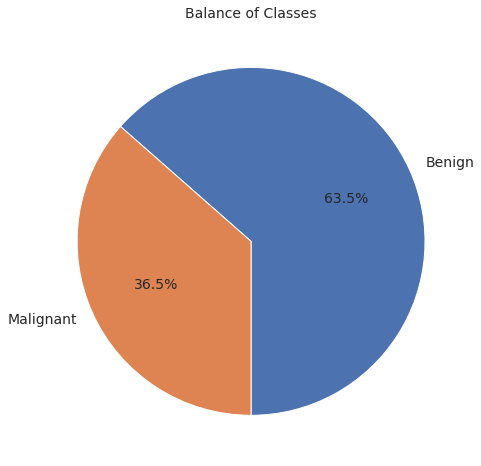

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Balance of Classes', fontsize=14)

eda.data['label']\
    .map({1: 'Malignant', 0: 'Benign'})\
    .value_counts()\
    .plot(
        ax=ax,
        kind='pie',
        autopct='%1.1f%%',
        startangle=270,
        fontsize=14,
        label=''
    )

plt.show()

### - Imbalanced Classes
&emsp;There are almost twice as many benign observations than malignant, which can become an issue while inducing machine learning models. We can either employ a sampling technique or adjust our assessment of models to account for such imbalance. The former entails taking advantage of techniques such as SMOTE to generate new samples that follow the distribution of a give class, the latter means going beyond accuracy measures and throroughly assessing the assumptions and aims of other methods such as Confusion Matrix and Reliability Diagrams.<br />
<br />

<!-- <center><img style="margin-bottom:5mm" src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png"><center/>
<center>Figure 1. Approaches to resampling<center/>
<center style="margin-bottom:5mm">Source. https://tinyurl.com/yy2qtbe2<center/>
 -->

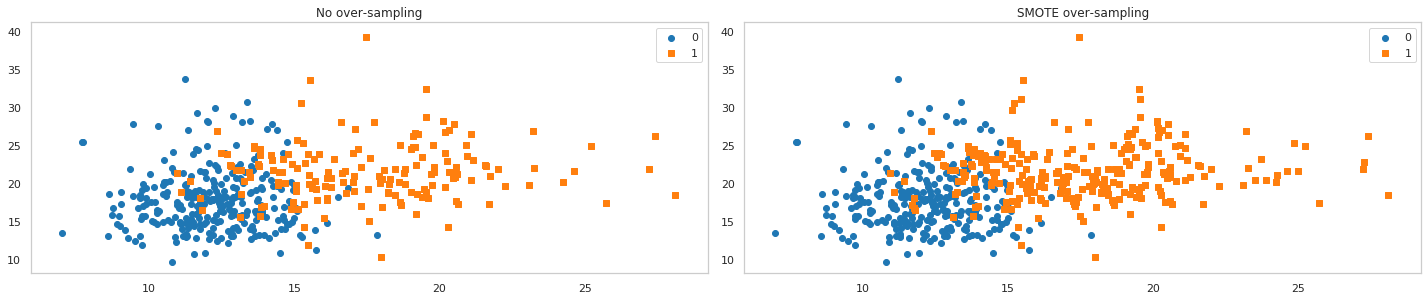

In [10]:
from imblearn.over_sampling import SMOTE

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')


smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(data.values, labels.values)

f = plt.figure(figsize=(20,8))

plt.subplot(2, 2, 1)
plot_2d_space(data.values, labels.values, 'No over-sampling')

plt.subplot(2, 2, 2)
plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

plt.tight_layout()


plt.show()

> For now, we choose to employ better assessment methods so as to avoid injecting bias into the dataset due to the delicate nature of this study.

&emsp;Before proceeding to the classifier induction task, we investigate the distribution of our features, comprised of some **statistical analysis** and **data visualization**, and whether there are any redundant candidates for removal via **correlation clustering**.<p/>

### - Feature Distribution

In [11]:
from scipy.stats import boxcox, skew

def plot_compare_classdistribution(in_df: pd.DataFrame, summary=None, ax=None, feats=None):
    '''
    '''
    try:
        df = in_df[feats].apply(preprocessing.scale, axis=0).copy()
    
    except KeyError:
        df = in_df.apply(preprocessing.scale, axis=0).copy()

    try:
        data = df.xs(summary, level='summaries', axis=1)
    
    except KeyError:
        data = df

    # melts columns' (name, value) pair into two columns
    df =\
        pd.melt(
            pd.concat(
                [
                    eda.data.droplevel(1, axis=1)['label'],
                    data
                ],
                axis=1
            ),
            id_vars='label',
            var_name='features',
            value_name='value'
        )

    # plots comparative distribution of classes for each 'mean' feature
    return\
        sns.violinplot(
            ax=ax,
            data=df,
            y="value",
            x="features",
            hue="label",
            inner="quartile",
            split=True,
        )


def transform_skew(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Transforms data with Boxcox transformation
    Keeps the transformation only if it is less skewed than the original
    '''
    skew_transformed = pd.DataFrame()

    for feat in df:

        data = df[feat].values
        posdata = data[data > 0]
        # posdata = eda.data[eda.data[feat]>0][feat]

        x, lmbda = boxcox(posdata, lmbda=None)
        
        transform = np.empty_like(data)
        transform[data > 0] = x
        transform[data == 0] = -1/lmbda

        if abs(skew(transform)) < abs(skew(data)):
            skew_transformed[feat] = transform

        else:
            skew_transformed[feat] = data
    
    skew_transformed.columns =\
        pd.MultiIndex.from_tuples(
            list(skew_transformed.columns),
            names=('summaries', 'attributes')
        )

    return skew_transformed

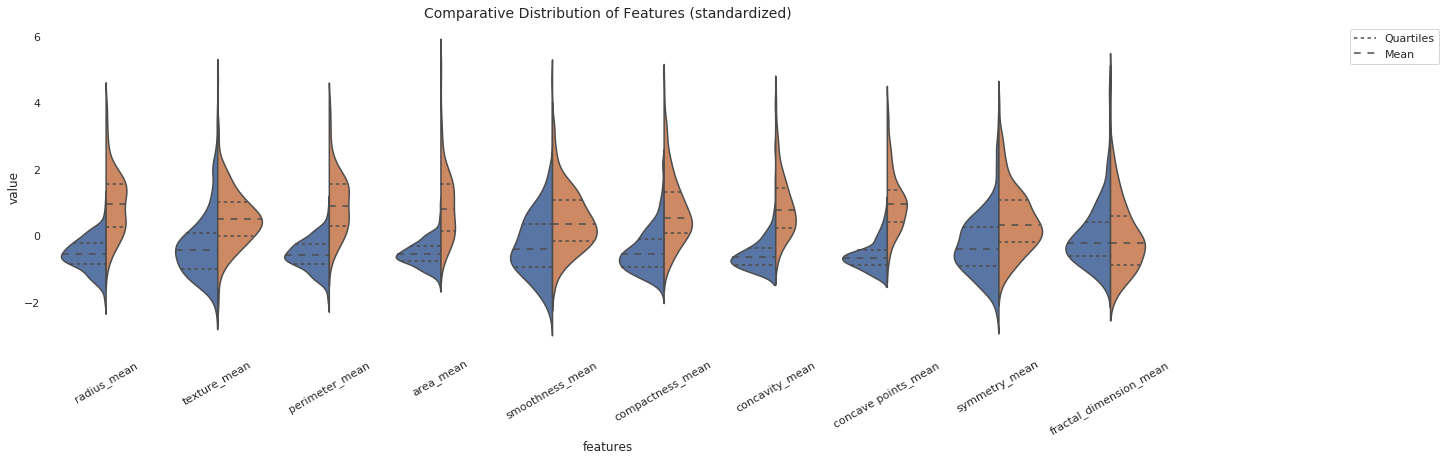

In [12]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.set_title('Comparative Distribution of Features (standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(data, ax=ax, summary='mean')

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
leg = ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [13]:
print('Skewness of features:')
eda.data.skew().sort_values(ascending=False).sort_index(level='summaries', sort_remaining=False)

Skewness of features:


summaries  attributes             
mean       area_mean                  1.755046
           concavity_mean             1.418262
           fractal_dimension_mean     1.368341
           concave points_mean        1.197001
           compactness_mean           1.196149
           perimeter_mean             1.092769
           radius_mean                1.043665
           texture_mean               0.727092
           symmetry_mean              0.688869
           smoothness_mean            0.497859
std        area_se                    5.592587
           concavity_se               5.215852
           fractal_dimension_se       4.007863
           perimeter_se               3.621360
           radius_se                  3.268179
           symmetry_se                2.261277
           compactness_se             1.932220
           smoothness_se              1.808871
           texture_se                 1.665838
           concave points_se          1.390286
meanmax3   area_worst    

In [14]:
print('Applies boxcox transformation')
transformed = transform_skew(data)
transformed['label'] = labels.values

Applies boxcox transformation


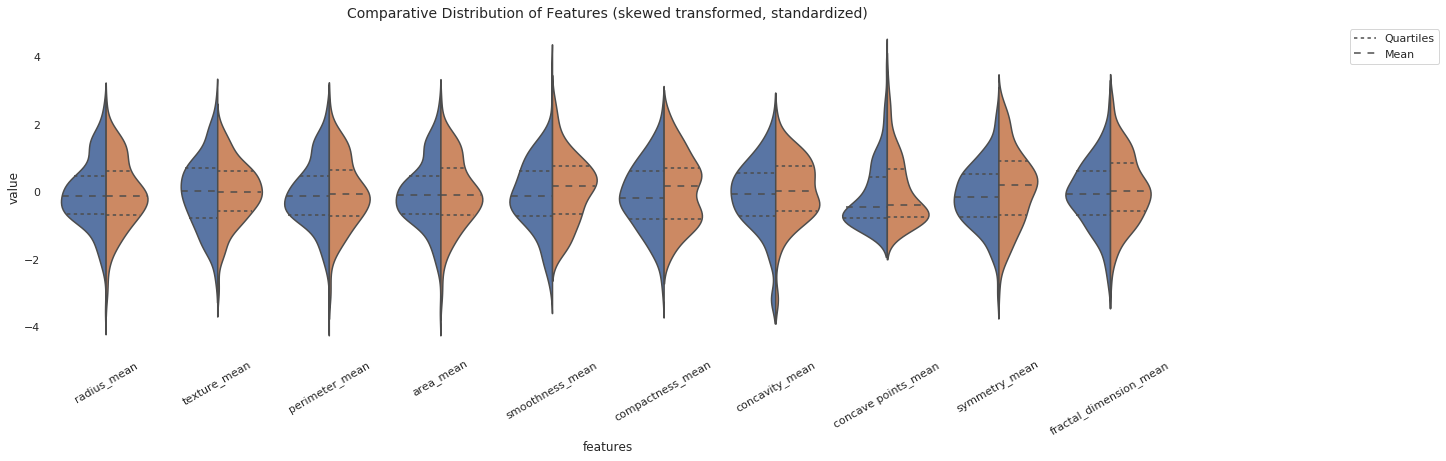

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.set_title('Comparative Distribution of Features (skewed transformed, standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(transformed, summary='mean')

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [16]:
print('Skewness after Boxcox transform:')
transformed.skew().sort_values(ascending=False).sort_index(level='summaries', sort_remaining=False)

Skewness after Boxcox transform:


summaries  attributes             
mean       concave points_mean        1.197001
           fractal_dimension_mean     0.009648
           perimeter_mean             0.006937
           radius_mean                0.005953
           area_mean                  0.004317
           texture_mean               0.000130
           smoothness_mean           -0.000019
           compactness_mean          -0.002551
           symmetry_mean             -0.002632
           concavity_mean            -0.573035
meanmax3   concave points_worst       0.492650
           perimeter_worst            0.036916
           radius_worst               0.035647
           area_worst                 0.032363
           fractal_dimension_worst    0.027499
           smoothness_worst           0.002130
           texture_worst             -0.003132
           compactness_worst         -0.006102
           symmetry_worst            -0.030305
           concavity_worst           -0.353204
std        concave points

### - Correlation Analysis

In [17]:
def get_unique_correlation(data: pd.DataFrame, threshold=0.5) -> pd.DataFrame:
    try:
        tmp = data.drop('label', axis=1).copy()
    
    except KeyError:
        pass

    tmp.columns = tmp.columns.to_flat_index()
    dataCorr = tmp.corr(method='pearson')

    dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool))
    dataCorr = dataCorr[abs(dataCorr) >= threshold].stack()

    dataCorr = dataCorr.reset_index(level=0)
    dataCorr.index = pd.MultiIndex.from_tuples(dataCorr.index, names=('summaries', 'attributes'))
    
    return dataCorr.sort_index(level='attributes').sort_index(level='summaries', sort_remaining=False)

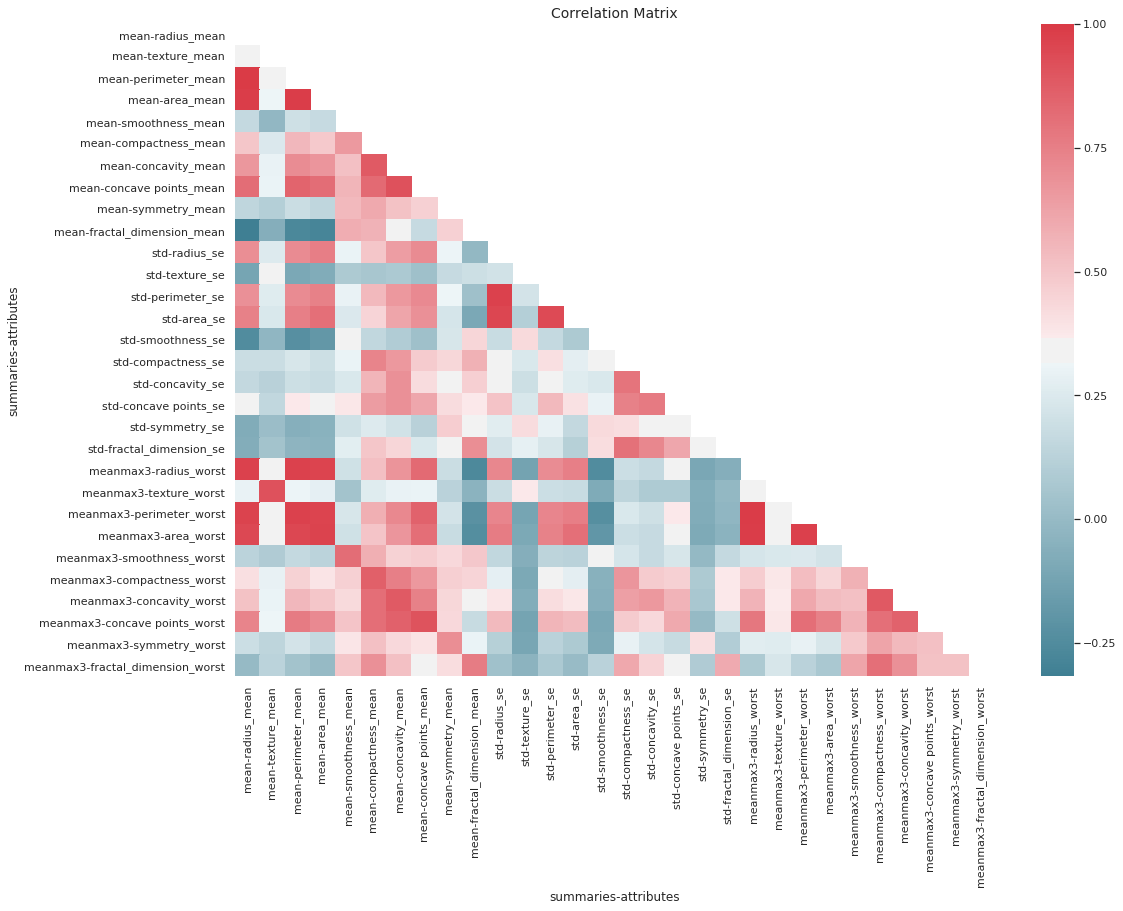

In [18]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(17, 12))
ax.set_title('Correlation Matrix', fontsize=14)

corr = data.corr()

# generates an upper diagonal mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    ax=ax,
    vmax=1,
    cmap=cmap,
    mask=mask,
    annot=False,
    square=False,
)

plt.show()

**Feature Selection Stategy**<br />
&emsp;Before applying an automated search for the optimal dimensionality for each classifer, we investigate features we consider relevant for the sake of comparison. There are a few features (variables) that correlate with many others, which could lead to using them to represent all others. At the end of this process, we will be able to answer **RQ1**.
* What are the most significant features, and how to measure significance? (RQ1)

**Correlation clustering** is the task of ...

In [19]:
def correlation_clustering(corr: np.ndarray, labels=None, threshold=0.5, ax=plt.axes, maxclust=None) -> (dict or np.ndarray):
    '''
    '''
    dissimilarity = 1 - np.abs(corr)
    hierarchy = linkage(squareform(dissimilarity), method='ward', metric='distance')
    
    return\
        (
            fcluster(hierarchy, maxclust, criterion='maxclust') if maxclust
            else
            dendrogram(
                hierarchy, color_threshold=None,
                labels=labels, ax=ax,
                distance_sort='ascending',
                leaf_font_size=12,
                orientation='right',
            )
        )
        

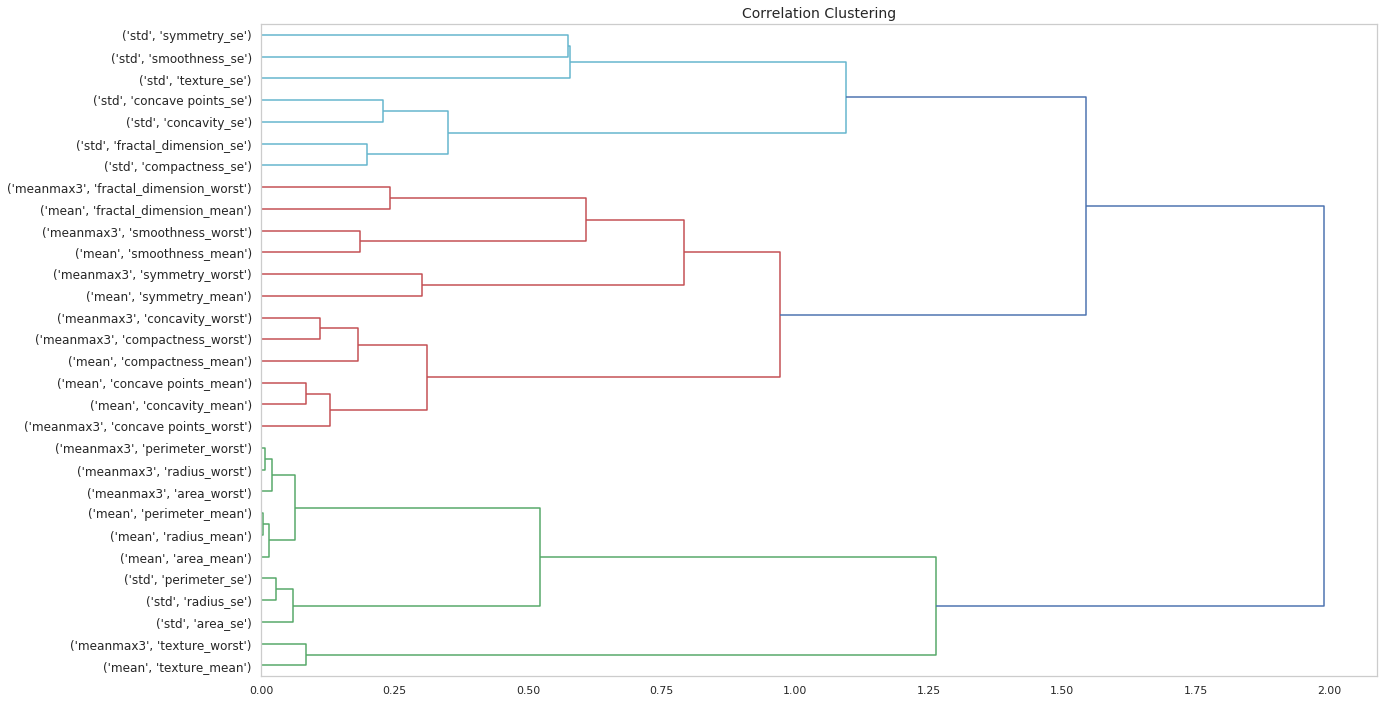

In [20]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.set_title('Correlation Clustering', fontsize=14)

d = correlation_clustering(corr.values, corr.index.values, ax=ax)

# plt.xticks(rotation=90)
plt.show()


In [21]:
# groups features into their respective clusters
cluster = correlation_clustering(corr.values, labels=corr.index.values, maxclust=3)
cluster =\
    pd.Series(cluster, corr.index.values, name='cluster')\
        .reset_index().groupby('cluster')['index'].apply(np.array)\
        .to_dict()

In [22]:
import plotly.graph_objects as go
from IPython.display import display
from plotly.subplots import make_subplots
from ipywidgets import interact, interact_manual

@interact
def viz_cluster_separation(
    feature1=[pair[0] +'_'+ pair[1] for pair in cluster[1]],
    feature2=[pair[0] +'_'+ pair[1] for pair in cluster[2]],
    feature3=[pair[0] +'_'+ pair[1] for pair in cluster[3]]
):
    '''
    '''
    feature1 = tuple(feature1.split('_', 1))
    feature2 = tuple(feature2.split('_', 1))
    feature3 = tuple(feature3.split('_', 1))

    fig =\
        make_subplots(
            rows=1, cols=2,
            specs=[
                [{'is_3d': True}, {'is_3d': True}]
            ],
            print_grid=False,
            subplot_titles=('Original features', 'Standardized features')
        )

    x = data[feature1]
    y = data[feature2]
    z = data[feature3]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            showlegend=False,
            
            marker=dict(
                size=6,
                color=labels.values,
                colorscale=['#CC8963', '#5875A4'],
                opacity=1.0
            )
        ),
        row=1, col=1
    )

    x = transformed[feature1]
    y = transformed[feature2]
    z = transformed[feature3]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            showlegend=False,
            marker=dict(
                size=6,
                color=labels.values,
                colorscale=['#CC8963', '#5875A4'],
                opacity=1.0
            )
        ),
        row=1, col=2
    )

    fig.update_layout(
        width=1200,
        height=600,
        margin=dict(r=10, l=10, b=10, t=10),
        title_text='Class separation',
        scene = dict(
            xaxis_title=feature1[0] +'_'+ feature1[1],
            yaxis_title=feature2[0] +'_'+ feature2[1],
            zaxis_title=feature3[0] +'_'+ feature3[1]
        )
    )

    fig.show()


interactive(children=(Dropdown(description='feature1', options=('mean_radius_mean', 'mean_texture_mean', 'mean…

What are the most significant features, and how to measure significance? **(RQ1)**

In [23]:
print('Selects the feature that has highest correlation to target variable ("label") within each cluster.')
target = eda.data.corr()[('label', '')]
selected_feats = [target[cluster[k]].idxmax() for k in cluster.keys()]
selected_feats

Selects the feature that has highest correlation to target variable ("label") within each cluster.


[('meanmax3', 'perimeter_worst'),
 ('meanmax3', 'concave points_worst'),
 ('std', 'concave points_se')]

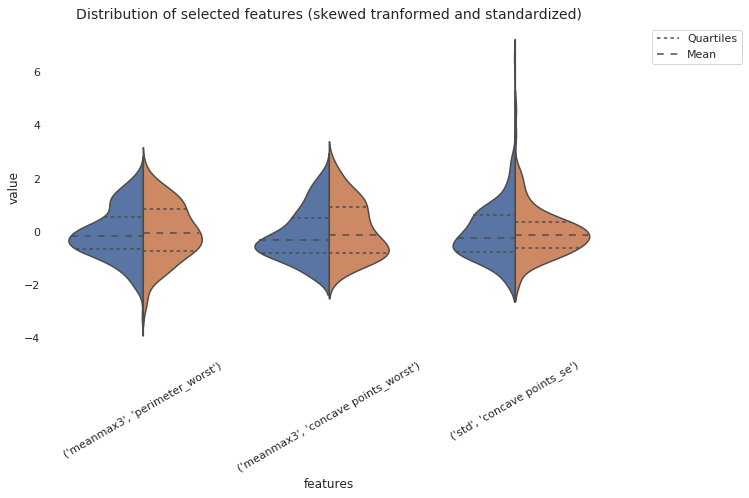

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_title('Distribution of selected features (skewed tranformed and standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(transformed, ax=ax, feats=selected_feats)

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
leg = ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

# 3. Classification

In [25]:
from sklearn.model_selection import train_test_split

# splits data and labels
X = data.values
y = labels.values

# # splits train and test
# X_train, X_test, y_train, y_test =\
#     train_test_split(
#         X,
#         y,
#         test_size=.2,
#         random_state=42
#     )

## 3.1 Model Selection and Induction
Which classifiers are most suitable for the task, and how to decide? **(RQ2)**

When choosing a solution to a problem, one must keep in mind the principle of Occam's Razor, which states that given two equally effective solutions, the simpler one is more likely to be the correct one. ~~Thus, having visually observed that our selected features nearly separate the classes linearly, we choose linear models for classification. However we must also test this assumption (classes are linearly separable) so that we have more confidence in our classification. We test our assumption by training linear kernel Support Vector Machine Classifier. If such classifier achieves perfect accuracy (100%), it means that our classes are linearly separable~~. Classes are not entirely linearly separable. Still, we keep the test in this document as evidence of it.

### - Test linear separability of classes

**-- Convex Hulls and Linear Programming**

In [26]:
#Drawing Convex Hulls to test for intersection 
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linprog

feats = [x[0]+'_'+x[1] for x in eda.data[selected_feats].columns.to_flat_index()]

@interact
def convex_hulls_separability(
    feature1=feats,
    feature2=feats[::-1]
):
    if feature1 != feature2:
        feats = [tuple(x.split('_', 1)) for x in [feature1, feature2]]
        d = eda.data[feats].copy()
        d.columns = d.columns.to_flat_index()
        d['label'] = labels.values
        label = labels.values

        plt.clf()
        plt.figure(figsize = (20, 6))
        names = ['Benign', 'Malignant']
        colors = ['#CC8963', '#5875A4']
        
        plt.title('{0} vs. {1}'.format(feature1.upper(), feature2.upper()))
        plt.xlabel(feature1)
        plt.ylabel(feature2)

        for i in range(len(names)):
            bucket = d[d['label'] == i]
            bucket = bucket.iloc[:,[0,1]].values
            hull = ConvexHull(bucket)
            plt.scatter(bucket[:, 0], bucket[:, 1], label=names[i]) 
            for j in hull.simplices:
                plt.plot(bucket[j,0], bucket[j,1], colors[i])

        plt.legend()
        plt.show()

        d["newlabel"] = np.where(d['label'] == 0, 1 , -1)

        sc = StandardScaler()
        tmp = d.iloc[:,[0,1]].values
        tmp = sc.fit_transform(tmp)

        xx = np.array(d['newlabel'].values.reshape(-1,1) * tmp)
        t = np.where(d['label'] == 0, 1 , -1)

        #2-D array which, when matrix-multiplied by x, gives the values of 
        #the upper-bound inequality constraints at x.
        A_ub = np.append(xx, t.reshape(-1,1), 1)

        #1-D array of values representing the upper-bound of each 
        #inequality constraint (row) in A_ub.
        b_ub = np.repeat(-1, A_ub.shape[0]).reshape(-1,1)

        # Coefficients of the linear objective function to be minimized.
        c_obj = np.repeat(1, A_ub.shape[1])
        res = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub,
                      options={"disp": False})

        if res.success:
            print('There is linear separability between Benign and Malignant via "{}" and "{}"'.format(feature1, feature2))
        else:
            print('No linear separability between Benign and Malignant via "{}" and "{}"'.format(feature1, feature2))
    
    else:
        print('Please, select two distinct features to draw hulls and check for separability')

interactive(children=(Dropdown(description='feature1', options=('meanmax3_perimeter_worst', 'meanmax3_concave …

In [27]:
del feats

&emsp;This test show us that although nearly, the classes are not fully linearly separable. This informs our choice of classifiers, which will favor non-linear ones such as RBF SVM, MLP, Random Forest and so on. Next, we induce our models and define metrics for comparison between models and data dimensionality.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier


# class ClfSwitcher(BaseEstimator):
#     '''
#     Boilerplate class to support hyperparameter tunning for multiple classifiers
#     '''
#     def __init__(
#         self, 
#         estimator = SGDClassifier(),
#     ): 
#         self.estimator = estimator


#     def fit(self, X, y=None, **kwargs):
#         self.estimator.fit(X, y)
#         return self


#     def predict(self, X, y=None):
#         return self.estimator.predict(X)


#     def predict_proba(self, X):
#         return self.estimator.predict_proba(X)


#     def score(self, X, y):
#         return self.estimator.score(X, y)

#     def decision_function(self, X):
#         return self.estimator.decision_function(X)



class Correlation_Clustering(TransformerMixin, BaseEstimator):
    '''
    
    '''
    def __init__(self, n_components=None):
        self.n_components = n_components
        
    def fit(self, X, y):
        if self.n_components:
            X = pd.DataFrame(X)
            cluster = correlation_clustering(
                X.corr().values, maxclust=self.n_components
            )

            X['label'] = y
            self.corr = X.corr()
            self.corr = self.corr.drop('label', axis=0)
            self.corr['cluster'] = cluster
        
        return self

    def transform(self, X):
        '''
        Apply dimensionality reduction to X via correlation clustering
        NOT OPTMIZED AT ALL!!
        '''
        try:
            sel =\
                self.corr.groupby('cluster')['label']\
                    .apply(lambda x: x.idxmax()).values
        
        except AttributeError:
            pass
        
        return X[:, sel] if self.n_components else X



class Skew_Scale(TransformerMixin, BaseEstimator):
    '''
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    
    def transform(self, X):
        result = np.empty_like(X)
        for col, i in zip(X.T, range(len(X.T))):
            y, lmbda = boxcox(col[col > 0], lmbda=None)
            transform = np.empty_like(col)
            transform[col > 0] = y
            transform[col == 0] = -1/lmbda

            if abs(skew(transform)) < abs(skew(col)):
                result.T[i] = transform
            else:
                result.T[i] = col

        return preprocessing.scale(result)

In [29]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# pipeline = Pipeline([
#     ('preprocessing', 'passthrough'),
#     ('reduce_dim', 'passthrough'),
#     ('clf', ClfSwitcher()),
# ])

# param_grid =  [
#     {
#         'clf__estimator': [SVC()],
# #         'preprocessing': [Skew_Scale()],
#         'reduce_dim': [Correlation_Clustering()],
#         'reduce_dim__n_components': [3, 5],
#         #---------------------------------------------------
#         'clf__estimator__kernel': ['rbf'],
#         'clf__estimator__gamma': ['scale'],
#         'clf__estimator__tol': [1e-3, 1e-2, 1e-1],
#         'clf__estimator__C': [1.0, 50, 1e2],
#         'clf__estimator__max_iter': [-1],
#         'clf__estimator__class_weight': ['balanced', None]
#     },
#     {
#         'clf__estimator': [RandomForestClassifier()],
# #         'preprocessing': [Skew_Scale()],
#         'reduce_dim': [Correlation_Clustering()],
#         'reduce_dim__n_components': [3, 5],
#         #---------------------------------------------------
#         'clf__estimator__criterion': ['gini'],
#         'clf__estimator__min_samples_split': [3, 5, 7],
#         'clf__estimator__min_impurity_decrease': [1e-1],
#         'clf__estimator__n_estimators': [200, 250],
#         'clf__estimator__oob_score': [False],
#         'clf__estimator__class_weight': ['balanced', 'balanced_subsample'],
#         'clf__estimator__ccp_alpha': [1e-1],
#         'clf__estimator__bootstrap': [True],
#         'clf__estimator__max_samples': [.1, .15, .2],
#         'clf__estimator__max_leaf_nodes': [100, 200, 300],
#         'clf__estimator__min_samples_leaf': [1, 3],
#     },
#     {
#         'clf__estimator': [MLPClassifier()],
#         #         'preprocessing': [Skew_Scale()],
#         'reduce_dim': [Correlation_Clustering()],
#         'reduce_dim__n_components': [3, 5],
#         #---------------------------------------------------
#         'clf__estimator__hidden_layer_sizes': [(100, ), (100, 2)],
#         'clf__estimator__activation': ['relu'],
#         'clf__estimator__solver': ['adam'],
#         'clf__estimator__alpha': [0.0001],
#         'clf__estimator__batch_size': ['auto'],
#         'clf__estimator__learning_rate': ['constant'],
#         'clf__estimator__learning_rate_init': [0.001],
#         'clf__estimator__power_t': [0.5],
#         'clf__estimator__max_iter': [200],
#         'clf__estimator__shuffle': [True],
#         'clf__estimator__random_state': [None],
#         'clf__estimator__tol': [0.0001],
#         'clf__estimator__verbose': [False],
#         'clf__estimator__warm_start': [False],
#         'clf__estimator__momentum': [0.9],
#         'clf__estimator__nesterovs_momentum': [True],
#         'clf__estimator__early_stopping': [False],
#         'clf__estimator__validation_fraction': [0.1],
#         'clf__estimator__beta_1': [0.9],
#         'clf__estimator__beta_2': [0.999],
#         'clf__estimator__epsilon': [1e-08],
#         'clf__estimator__n_iter_no_change': [10],
#         'clf__estimator__max_fun': [15000]
#     },
# ]

In [30]:
# # scales data
# ss = Skew_Scale()
# ss.fit(X, y)
# X = ss.transform(X)

# # fits models in pipeline
# gscv = GridSearchCV(
#     pipeline, param_grid,
#     scoring=['f1_weighted', 'roc_auc'],
#     refit='roc_auc',
#     cv=5, n_jobs=-1, verbose=3
# )
# gscv.fit(X, y)
# # gscv.fit(X_sm, y_sm)

In [31]:
# # summarize results
# print("Best: %f using %s" % (gscv.best_score_, gscv.best_params_), '\n')

**-- Final choice of models**

In [32]:
clf = {
    'rf': RandomForestClassifier(
        bootstrap=True, ccp_alpha=0.01, class_weight='balanced',
        criterion='gini', max_depth=None, max_features='auto',
        max_leaf_nodes=100, max_samples=0.15,
        min_impurity_decrease=0.1, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=3,
        min_weight_fraction_leaf=0.0, n_estimators=250,
        n_jobs=None, oob_score=False, random_state=None,
        verbose=0, warm_start=False
    ),
    'svm': SVC(
        C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
        max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.01,
        verbose=False
    ),
    'mlp': MLPClassifier(
        activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='constant',
        learning_rate_init=0.001, max_fun=15000, max_iter=200,
        momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
        power_t=0.5, random_state=None, shuffle=True, solver='adam',
        tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False
    )
}

## 3.2 Assessing Results
What performance measure should be favored during hyperparameter tuning? **(RQ3)**

How much better (or worse) are classifiers induced from reduced dimensionality? **(RQ4)**

In [33]:
# realoads the data fresh
X_train = data.values
y_train = labels.values

X_test = eda.holdout.drop(('label', ''), axis=1).values
y_test = eda.holdout.droplevel(1, axis=1)['label'].values

# transforms skew and scales
ss = Skew_Scale()
ss.fit(X_train, y_train)
X_train = ss.transform(X_train)
ss.fit(X_test, y_test)
X_test = ss.transform(X_test)

# reduces dimensionality
reduce_dim = Correlation_Clustering(n_components=3)
reduce_dim.fit(X_train, y_train)
x_train = reduce_dim.transform(X_train)
reduce_dim.fit(X_test, y_test)
x_test = reduce_dim.transform(X_test)

# fits classifiers to the train data
[clf[model].fit(X_train, y_train) for model in clf.keys()]

# generates predictions
y_pred = {
    model: clf[model].predict(X_test)
    for model in clf.keys()
}

/home/ottok92/miniconda3/envs/dummy/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



### - Confusion Matrix

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

def plot_confusion_matrix(
    y_test: list, y_pred: list,
    benign_count: int, malignant_count: int,
#     axes: plt.axes
):
    '''
    '''
    cfn_matrix = confusion_matrix(y_test, y_pred)
    cfn_norm_matrix = np.array(
        [
            [1.0 / benign_count, 1.0 / benign_count],
            [1.0 / malignant_count, 1.0 / malignant_count]
        ]
    )
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
#     plt.tight_layout()

    
    return sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True)


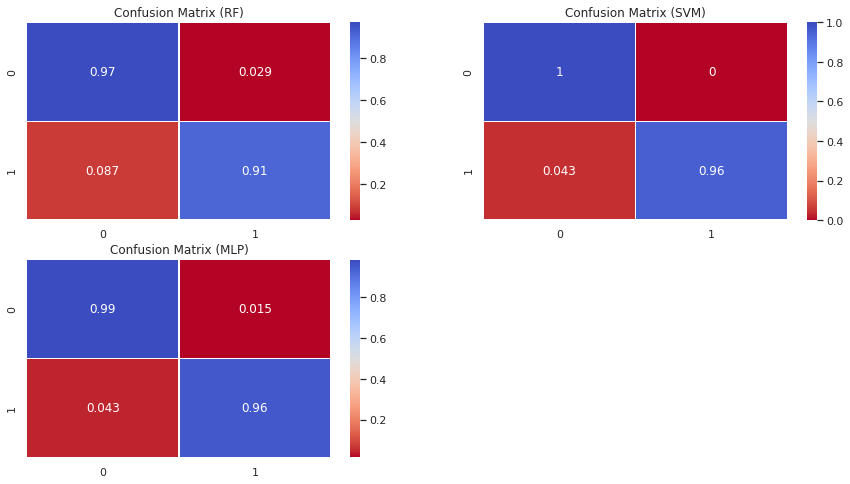

In [35]:
fig = plt.figure(figsize=(15,8))

for model, index in zip(list(clf.keys()), range(1, (len(clf.keys())+1))):
    fig.add_subplot(2,2,index)
    plt.title('Confusion Matrix ('+model.upper()+')')
    plot_confusion_matrix(y_test, y_pred[model], (y_test == 0).sum(), (y_test == 1).sum())

In [36]:
### - Reliability Diagrams

In [37]:
# from sklearn.calibration import calibration_curve
# from sklearn.calibration import CalibratedClassifierCV

# # predict uncalibrated probabilities
# def uncalibrated(X_train, X_test, y_train, model):
#     # predict probabilities
#     try:
#         result = clf[model].predict_proba(X_test)[:, 1]
#     except AttributeError:
#         result = clf[model].decision_function(X_test)
    
#     return result
 
# # predict calibrated probabilities
# def calibrated(X_train, X_test, y_train):
#     # define and fit calibration model
#     calibrated = CalibratedClassifierCV(clf['svm'], method='sigmoid', cv=5)
#     calibrated.fit(X_train, y_train)
#     # predict probabilities
#     return calibrated.predict_proba(X_test)[:, 1]

# fig = plt.figure(figsize=(15,8))

# # uncalibrated predictions
# for model in clf.keys():
#     unc = uncalibrated(X_train, X_test, y_train, model)
#     fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, unc, n_bins=10, normalize=True)
#     # plot model reliabilities
#     plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label=model.upper())
    
# # calibrated predictions
# cal = calibrated(X_train, X_test, y_train)
# fop_calibrated, mpv_calibrated = calibration_curve(y_test, cal, n_bins=10)
# plt.plot(mpv_calibrated, fop_calibrated, marker='.', label='Calibrated SVM')

# # plot perfectly calibrated
# plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# # plt.plot(mpv_calibrated, fop_calibrated, marker='.')
# plt.legend(loc='best')
# plt.show()

### - Precision Recall Curve vs ROC Curve

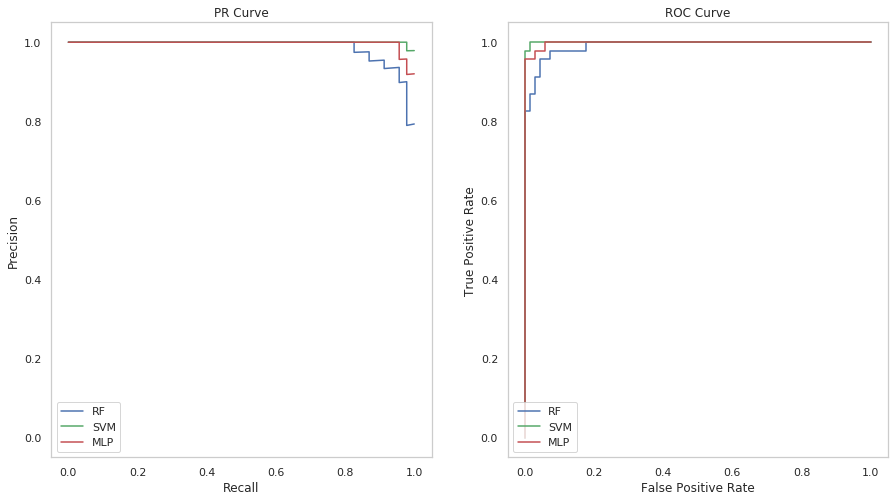

In [38]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for model, color in zip(clf.keys(),'bgr'):
    
    try:
        pred_prob = clf[model].predict_proba(X_test)[:,1]
    
    except AttributeError:
        pred_prob = clf[model].decision_function(X_test)[:,1]

    p,r,_ = precision_recall_curve(y_test, pred_prob)
    tpr,fpr,_ = roc_curve(y_test, pred_prob)
    
    ax1.plot(r, p, c=color, label=model.upper())
    ax2.plot(tpr, fpr, c=color, label=model.upper())
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

## 3.3 Results

In [39]:
for model in clf.keys():
    print('---Classification Report ('+model.upper()+')---')
    print(classification_report(y_test, y_pred[model]))

---Classification Report (RF)---
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        68
           1       0.95      0.91      0.93        46

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

---Classification Report (SVM)---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        68
           1       1.00      0.96      0.98        46

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

---Classification Report (MLP)---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        68
           1       0.98      0.96      0.97        46

    accuracy                           0.97       114
   macro avg       0.97    